In [1]:
import os
import cv2
import numpy as np
from collections import defaultdict
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
import mediapipe as mp
from tqdm import tqdm
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint


In [2]:
# Пути к данным
assert 1 == 0, "ПЕРЕД ИСПОЛЬЗОВАНИЕМ КОДА УБЕДИТЕСЬ, ЧТО ВЫ ВСТАВИЛИ ПУТЬ НИЖЕ" # TODO
path = ""
source_directory = f'{path}/Train'
test_directory = f'{path}/Test'
val_directory = f'{path}/Val'
video_extensions = {'.mp4', '.avi', '.mov', '.mkv', '.flv', '.wmv'}


AssertionError: ПЕРЕД ИСПОЛЬЗОВАНИЕМ КОДА УБЕДИТЕСЬ, ЧТО ВЫ ВСТАВИЛИ ПУТЬ НИЖЕ

In [3]:
# Получаем название классов в алфавитном порядке.
class_names = sorted([d for d in os.listdir(source_directory) if os.path.isdir(os.path.join(source_directory, d))])
# количество классов
num_classes = len(class_names)

In [4]:
# Считает, сколько видео в каждом классе
folders_by_video_count = defaultdict(list) #словарь где ключ - кол-во видео, значение - классы
for foldername in class_names:
    folderpath = os.path.join(source_directory, foldername) #
    count_videos = sum(1 for fname in os.listdir(folderpath) if os.path.splitext(fname)[1].lower() in video_extensions)
    if count_videos > 0:
        folders_by_video_count[count_videos].append(foldername)

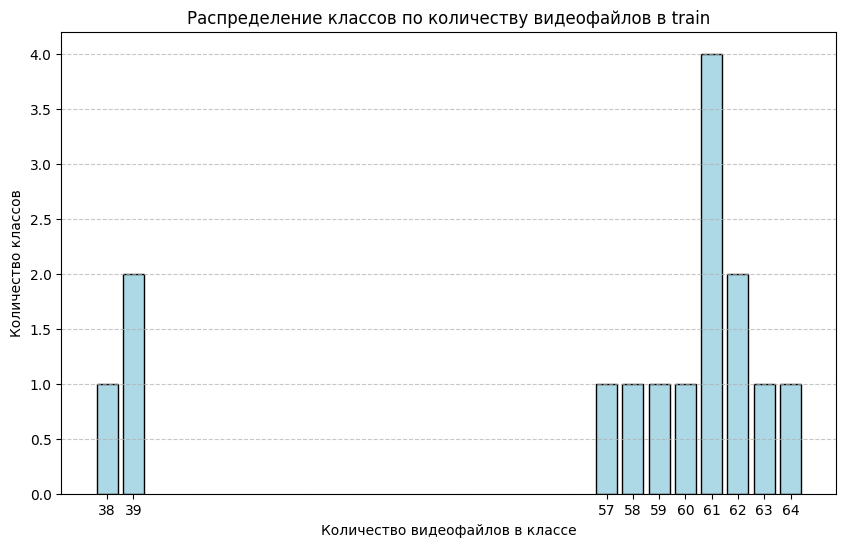

In [5]:
#TODO перевернуть
counts = list(folders_by_video_count.keys())
num_folders = [len(folders_by_video_count[count]) for count in counts]
if counts:

    sorted_pairs = sorted(zip(counts, num_folders))
    sorted_counts, sorted_num_folders = zip(*sorted_pairs)
    plt.figure(figsize=(10, 6))
    plt.bar(sorted_counts, sorted_num_folders, color='lightblue', edgecolor='black')
    plt.xlabel('Количество видеофайлов в классе')
    plt.ylabel('Количество классов')
    plt.title('Распределение классов по количеству видеофайлов в train')
    plt.xticks(sorted_counts)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

In [6]:

# для руки 21 точка,
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(
    static_image_mode=False,
    max_num_hands=2,
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5
)
# для позы 33 точки
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(
    static_image_mode=False,
    model_complexity=1,
    smooth_landmarks=True,
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5
)

I0000 00:00:1762278904.065349  276451 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M3 Max
I0000 00:00:1762278904.070665  276451 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M3 Max
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1762278904.077092  276891 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1762278904.081051  276899 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


In [7]:
SEQUENCE_LENGTH = 30 #кол-во кадров на одно видео
NUM_FEATURES_HANDS = 21*3*2 #Кол-во точек для рук
NUM_FEATURES_POSE = 33*4  #кол-во точек для позы
TOTAL_FEATURES = NUM_FEATURES_HANDS + NUM_FEATURES_POSE # кол-во точек всего
CACHE_PATH = "dataset_cache.npy"
CACHE_LABELS_PATH = "labels_cache.npy"


def normalize_and_scale_hands(frame):
    if all(x == 0 for x in frame):
        return frame
    # Преобразовать плоский список в массив формы (N, 3),
    # где N — количество ключевых точек
    coords = np.array(frame).reshape(-1,3)
    wrist_x, wrist_y, wrist_z = coords[0]
    #Центрирование
    coords -= [wrist_x, wrist_y, wrist_z]

    scale = np.linalg.norm(coords[0] - coords[9])
    if scale > 0:
        coords /= scale
    # Вернуть плоский одномерный вектор
    return coords.flatten()

def extract_pose_features(frame):
    #читает изображение в rgb
    results_pose = pose.process(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

    if results_pose.pose_landmarks:
        coords = []
        #Собираем по каждому из 33 ориентиру 4 значения
        for lm in results_pose.pose_landmarks.landmark:
            coords.extend([lm.x, lm.y, lm.z, lm.visibility])
        coords = np.array(coords, dtype=np.float32)
        #точка для центрирования
        base_idx = 23
        #берем его координату при помощи среза
        base_x, base_y, base_z = coords[4*base_idx:4*base_idx+3]

        #перевод в формат (33,4)
        coords_reshaped = coords.reshape(-1,4)
        #центрирование относительно 23 точки
        coords_reshaped[:,:3] -= [base_x, base_y, base_z]

         # Масштаб — расстояние от таза до головы/носа (индекс 0 = Nose).
        # Это делает признаки инвариантными к масштабу (рост, дистанция до камеры).
        head_idx = 0
        head_dist = np.linalg.norm(coords_reshaped[head_idx, :3])
        # масштабируем только xyz visibiity не трогаем
        if head_dist > 0:
            coords_reshaped[:,:3] /= head_dist
        return coords_reshaped.flatten()
    else:
        return np.zeros(33*4, dtype=np.float32)


def extract_sequence_from_video(video_path):

    # открываем видео для покадрового чтения
    cap = cv2.VideoCapture(video_path)
    # список для хранения векторных признаков кадра
    frames = []
    # счетчик кадров
    frame_idx = 0
    while cap.isOpened():
        ret, frame = cap.read() # чтения кадра
        if not ret:
            break

        # берем каждый 2 кадр
        if frame_idx % 2 == 0:
            # руки
            # TODO сделать функцию для извлечения frame рук
            results_hands = hands.process(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
            hand_landmarks = []
            for h_idx in range(2):
                if results_hands.multi_hand_landmarks and h_idx < len(results_hands.multi_hand_landmarks):
                    for lm in results_hands.multi_hand_landmarks[h_idx].landmark:
                        # если найдена рука то зписываем его координаты
                        hand_landmarks.extend([lm.x, lm.y, lm.z])
                else:
                    # иначе заполняем нулями
                    hand_landmarks.extend([0.0]*63)

            # Нормализация рук: центрируем по запястью и масштабируем по сегменту 0→9 (MCP среднего пальца)
            # Это делает признаки инвариантными к сдвигу и масштабу, возвращает плоский np.ndarray
            hand_features = normalize_and_scale_hands(hand_landmarks)
            # извлечение точек позы
            pose_features = extract_pose_features(frame)
            # Объединение признаков
            feature_vector = np.concatenate([hand_features, pose_features])
            frames.append(feature_vector)
        # как только набираем нужное количество кадров, прекращаем чтение
        frame_idx += 1
        if len(frames) >= SEQUENCE_LENGTH:
            break
    cap.release()   # Освобождаем ресурсы видеодекодера
    # Дополнение нулями, если не хвататет кол-во кадров
    if len(frames) < SEQUENCE_LENGTH:
        pad = np.zeros(TOTAL_FEATURES, dtype=np.float32)
        frames.extend([pad]*(SEQUENCE_LENGTH - len(frames)))
     # Возвращаем тензор формы (SEQUENCE_LENGTH, TOTAL_FEATURES), dtype float32
    return np.array(frames, dtype=np.float32)


# Загружает датасет из каталогов класса:
    # directory/
    #   ├─ <class_name_1>/*.mp4|*.avi|...
    #   ├─ <class_name_2>/*.mp4|*.avi|...
    #   └─ ...
def load_data_from_directory(directory, selected_classes, video_extensions, augment=False):
    sequences = [] # накопитель признаковых последовательностей по видео
    labels = []  # накопитель меток классов, выровненных по sequences
    for class_idx, class_name in enumerate(selected_classes): # Перебор классов в заданном порядке; индекс class_idx будет использоваться как целевая метка
        class_dir = os.path.join(directory, class_name) # путь к папке конкретного класса
        video_files = [f for f in os.listdir(class_dir) if os.path.splitext(f)[1].lower() in video_extensions] # Список файлов видео по допустимым расширениям
        for video_file in video_files: # Обрабатываем каждое видео этого класса
            seq = extract_sequence_from_video(os.path.join(class_dir, video_file)) # Извлекаем последовательность признаков
            if augment: # Опциональная аугментация (шум/смещение и т.п.) — только для train
                seq = augment_sequence(seq)

            # Добавляем признаки и соответствующую метку класса
            sequences.append(seq)
            labels.append(class_idx)
    return np.array(sequences), np.array(labels)


def augment_sequence(seq):
    """Data augmentation — шум + небольшое смещение"""
    noise = np.random.normal(0, 0.01, seq.shape)
    shift = np.random.uniform(-0.05, 0.05, (1, seq.shape[1]))
    return seq + noise + shift


W0000 00:00:1762278904.122642  276909 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1762278904.128354  276909 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


In [8]:
selected_classes = class_names


# selected_classes = ['Благодарность_1', 'Говорить_3', 'Да_4', 'Знать_5', 'Пока_9']  # нужные тебе классы

num_classes = len(selected_classes)

In [9]:

# загруза данных

X_train, y_train = load_data_from_directory(source_directory, selected_classes, video_extensions, augment=True)
X_val, y_val = load_data_from_directory(val_directory, selected_classes, video_extensions)
X_test, y_test = load_data_from_directory(test_directory, selected_classes, video_extensions)

/Users/denis/PycharmProjects/PythonProject8/.venv/lib/python3.10/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


In [10]:
from tensorflow.keras.utils import to_categorical
#кэф сглаживания
label_smoothing_factor = 0.1

# Перевод целочисленных меток в one-hot: форма (N, num_classes)
y_train_cat = to_categorical(y_train)
y_train_cat = y_train_cat * (1 - label_smoothing_factor) + (label_smoothing_factor / y_train_cat.shape[1])

y_val_cat = to_categorical(y_val)
y_val_cat = y_val_cat * (1 - label_smoothing_factor) + (label_smoothing_factor / y_val_cat.shape[1])

y_test_cat = to_categorical(y_test)
y_test_cat = y_test_cat * (1 - label_smoothing_factor) + (label_smoothing_factor / y_test_cat.shape[1])


In [11]:
# Сазаново предложила попробовать, другие активизаторы (sigmointol,tanh,и еще однй (Арсен помнит, но название забыл)
from tensorflow.keras.layers import (
    Input, Conv1D, BatchNormalization, Activation, MaxPooling1D, Dropout,
    Bidirectional, LSTM, GRU, MultiHeadAttention, Dense, LayerNormalization,
    GlobalAveragePooling1D, GlobalMaxPooling1D, Concatenate
)
from tensorflow.keras.models import Model
def build_model(sequence_len, num_features, num_classes, d_model=256, num_heads=4):
    inputs = Input(shape=(sequence_len, num_features))

    # Первый блок сверточных слоев выделяет локальные шаблоны
    x = Conv1D(128, 5, padding='same', use_bias=False)(inputs)
    x = BatchNormalization()(x); x = Activation('relu')(x) # нормализация ускоряет обучение
    x = Conv1D(128, 3, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x); x = Activation('relu')(x)
    x = MaxPooling1D(2)(x)  # уменьшаем длину последовательности в 2 раза
    x = Dropout(0.2)(x)

    # Второй блок сверточных слоев - более глубокие признаки
    x = Conv1D(256, 3, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x); x = Activation('relu')(x)
    x = Conv1D(256, 3, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x); x = Activation('relu')(x)
    x = MaxPooling1D(2)(x)
    x = Dropout(0.2)(x)

    #  двунаправленная LSTM запоминает долгосрочные зависимости
    x = Bidirectional(LSTM(256, return_sequences=True, dropout=0.2))(x)
    # двунаправленный GRU обрабатывает более короткие зависимости с меньшей вычислительной стоимостью
    x = Bidirectional(GRU(192, return_sequences=True, dropout=0.2))(x)

    # Проекция в d_model для внимания
    proj = Dense(d_model)(x)

    # каждый таймстеп “смотрит” на всю последовательность, чтобы собрать контекст из других позиций.
    attn_out = MultiHeadAttention(num_heads=num_heads, key_dim=d_model//num_heads, dropout=0.1)(proj, proj)
    x = LayerNormalization(epsilon=1e-5)(proj + attn_out)

    # блок — позиционно-основная FFN трансформера. Он по каждому таймстепу независимо делает расширение признаков до 4·d_model через ReLU, затем сжимает обратно до d_model, применяет дропаут для регуляризации и добавляет residual с последующей LayerNorm для стабильного градиентного потока
    ff = Dense(4*d_model, activation='relu')(x)
    ff = Dropout(0.1)(ff)
    ff = Dense(d_model)(ff)
    x = LayerNormalization(epsilon=1e-5)(x + ff)

    # Комбинированный пуллинг
    avg = GlobalAveragePooling1D()(x)
    mx = GlobalMaxPooling1D()(x)
    x = Concatenate()([avg, mx])

    #
    x = Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-5))(x)
    x = Dropout(0.3)(x)
    x = Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-5))(x)
    x = Dropout(0.2)(x)

    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    optimizer = tf.keras.optimizers.Adam(learning_rate=3e-4)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Использование
model9 = build_model(SEQUENCE_LENGTH, TOTAL_FEATURES, num_classes)
model9.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 30, 258)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 30, 128)   │    165,120 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 30, 128)   │        512 │ conv1d[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 30, 128)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 30, 128)   │     49,152 │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 30, 128)   │        512 │ conv1d_1[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 30, 128)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 15, 128)   │          0 │ activation_1[0][… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 15, 128)   │          0 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 15, 256)   │     98,304 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 15, 256)   │      1,024 │ conv1d_2[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 15, 256)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 15, 256)   │    196,608 │ activation_2[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 15, 256)   │      1,024 │ conv1d_3[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 15, 256)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_1     │ (None, 7, 256)    │          0 │ activation_3[0][… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 7, 256)    │          0 │ max_pooling1d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 7, 512)    │  1,050,624 │ dropout_1[0][0]   │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 7, 384)    │    813,312 │ bidirectional[0]

 Total params: 3,430,671 (13.09 MB)

 Trainable params: 3,429,135 (13.08 MB)

 Non-trainable params: 1,536 (6.00 KB)

In [12]:

callbacks = [
    EarlyStopping(patience=7,restore_best_weights=True),
    ReduceLROnPlateau(factor=0.5, patience=3, min_lr=1e-6), #сли выбранная метрика не улучшается 3 эпохи, уменьшает текущий learning rate в 2 раза (
    ModelCheckpoint('best_model.h5', save_best_only=True)
]


In [13]:
history3 = model9.fit(
    X_train, y_train_cat,
    epochs=100,
    batch_size=32,
    validation_data=(X_val, y_val_cat),
    callbacks=callbacks
)

Epoch 1/100
26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.0716 - loss: 3.0084

27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 75ms/step - accuracy: 0.0722 - loss: 2.8815 - val_accuracy: 0.0658 - val_loss: 2.7663 - learning_rate: 3.0000e-04
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - accuracy: 0.0923 - loss: 2.7087 - val_accuracy: 0.1053 - val_loss: 2.8825 - learning_rate: 3.0000e-04
Epoch 3/100
26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.1228 - loss: 2.6164

27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - accuracy: 0.1361 - loss: 2.6045 - val_accuracy: 0.1053 - val_loss: 2.6247 - learning_rate: 3.0000e-04
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.1540 - loss: 2.5642

27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 86ms/step - accuracy: 0.1645 - loss: 2.5389 - val_accuracy: 0.1316 - val_loss: 2.4784 - learning_rate: 3.0000e-04
Epoch 5/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.2195 - loss: 2.3758

27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step - accuracy: 0.2343 - loss: 2.3698 - val_accuracy: 0.1974 - val_loss: 2.3629 - learning_rate: 3.0000e-04
Epoch 6/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - accuracy: 0.2769 - loss: 2.2162 - val_accuracy: 0.2237 - val_loss: 2.4503 - learning_rate: 3.0000e-04
Epoch 7/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.3123 - loss: 2.1418

27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step - accuracy: 0.3112 - loss: 2.1346 - val_accuracy: 0.2632 - val_loss: 2.1911 - learning_rate: 3.0000e-04
Epoch 8/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - accuracy: 0.3633 - loss: 2.0550 - val_accuracy: 0.2368 - val_loss: 2.2580 - learning_rate: 3.0000e-04
Epoch 9/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.3693 - loss: 1.9362

27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 98ms/step - accuracy: 0.3491 - loss: 1.9639 - val_accuracy: 0.4605 - val_loss: 1.7708 - learning_rate: 3.0000e-04
Epoch 10/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.4318 - loss: 1.8834

27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step - accuracy: 0.4225 - loss: 1.8956 - val_accuracy: 0.4737 - val_loss: 1.6940 - learning_rate: 3.0000e-04
Epoch 11/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step - accuracy: 0.4544 - loss: 1.8075 - val_accuracy: 0.4605 - val_loss: 1.7573 - learning_rate: 3.0000e-04
Epoch 12/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.4738 - loss: 1.6861

27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step - accuracy: 0.4781 - loss: 1.6866 - val_accuracy: 0.4079 - val_loss: 1.6265 - learning_rate: 3.0000e-04
Epoch 13/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 98ms/step - accuracy: 0.5290 - loss: 1.6123 - val_accuracy: 0.4211 - val_loss: 1.8139 - learning_rate: 3.0000e-04
Epoch 14/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step - accuracy: 0.5385 - loss: 1.6080 - val_accuracy: 0.5395 - val_loss: 1.6920 - learning_rate: 3.0000e-04
Epoch 15/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.5561 - loss: 1.5808

27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 99ms/step - accuracy: 0.5751 - loss: 1.5582 - val_accuracy: 0.5132 - val_loss: 1.5643 - learning_rate: 3.0000e-04
Epoch 16/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.5556 - loss: 1.5487

27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - accuracy: 0.5609 - loss: 1.5441 - val_accuracy: 0.6842 - val_loss: 1.3070 - learning_rate: 3.0000e-04
Epoch 17/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - accuracy: 0.5882 - loss: 1.5033 - val_accuracy: 0.6579 - val_loss: 1.3679 - learning_rate: 3.0000e-04
Epoch 18/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - accuracy: 0.6130 - loss: 1.4267 - val_accuracy: 0.6316 - val_loss: 1.4936 - learning_rate: 3.0000e-04
Epoch 19/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step - accuracy: 0.6379 - loss: 1.3684 - val_accuracy: 0.5395 - val_loss: 1.6707 - learning_rate: 3.0000e-04
Epoch 20/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - accuracy: 0.6698 - loss: 1.3049 - val_accuracy: 0.6842 - val_loss: 1.3533 - learning_rate: 1.5000e-04
Epoch 21/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.7519 - loss: 1.1888

27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step - accuracy: 0.7432 - loss: 1.1939 - val_accuracy: 0.7500 - val_loss: 1.1519 - learning_rate: 1.5000e-04
Epoch 22/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.7248 - loss: 1.1992

27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 98ms/step - accuracy: 0.7243 - loss: 1.2153 - val_accuracy: 0.8026 - val_loss: 1.0390 - learning_rate: 1.5000e-04
Epoch 23/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.8027 - loss: 1.1151

27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - accuracy: 0.7917 - loss: 1.1195 - val_accuracy: 0.8289 - val_loss: 0.9724 - learning_rate: 1.5000e-04
Epoch 24/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step - accuracy: 0.7716 - loss: 1.1488 - val_accuracy: 0.7500 - val_loss: 1.0019 - learning_rate: 1.5000e-04
Epoch 25/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 85ms/step - accuracy: 0.8024 - loss: 1.0898 - val_accuracy: 0.8158 - val_loss: 1.0393 - learning_rate: 1.5000e-04
Epoch 26/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - accuracy: 0.7799 - loss: 1.1340 - val_accuracy: 0.7500 - val_loss: 1.0963 - learning_rate: 1.5000e-04
Epoch 27/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - accuracy: 0.7751 - loss: 1.1342 - val_accuracy: 0.8158 - val_loss: 1.0054 - learning_rate: 7.5000e-05
Epoch 28/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - accuracy: 0.8308 - loss: 1.0198 - val_accuracy: 0.8289 - val_loss: 0.9875 - learning_rate: 7.5000e-05
Epoch 29/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.8288

27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step - accuracy: 0.8225 - loss: 1.0349 - val_accuracy: 0.8816 - val_loss: 0.9227 - learning_rate: 7.5000e-05
Epoch 30/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 99ms/step - accuracy: 0.8249 - loss: 1.0082 - val_accuracy: 0.8684 - val_loss: 0.9638 - learning_rate: 7.5000e-05
Epoch 31/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 100ms/step - accuracy: 0.8686 - loss: 0.9589 - val_accuracy: 0.8553 - val_loss: 0.9343 - learning_rate: 7.5000e-05
Epoch 32/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.8671 - loss: 0.9554

27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 98ms/step - accuracy: 0.8462 - loss: 0.9866 - val_accuracy: 0.8947 - val_loss: 0.8575 - learning_rate: 7.5000e-05
Epoch 33/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - accuracy: 0.8509 - loss: 0.9885 - val_accuracy: 0.8816 - val_loss: 0.9353 - learning_rate: 7.5000e-05
Epoch 34/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step - accuracy: 0.8544 - loss: 0.9673 - val_accuracy: 0.8421 - val_loss: 0.9639 - learning_rate: 7.5000e-05
Epoch 35/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 85ms/step - accuracy: 0.8402 - loss: 0.9879 - val_accuracy: 0.9079 - val_loss: 0.8801 - learning_rate: 7.5000e-05
Epoch 36/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.8878 - loss: 0.9107

27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - accuracy: 0.8722 - loss: 0.9344 - val_accuracy: 0.9079 - val_loss: 0.8459 - learning_rate: 3.7500e-05
Epoch 37/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step - accuracy: 0.8675 - loss: 0.9155 - val_accuracy: 0.9079 - val_loss: 0.8493 - learning_rate: 3.7500e-05
Epoch 38/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.8876 - loss: 0.8935

27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step - accuracy: 0.8710 - loss: 0.9312 - val_accuracy: 0.8947 - val_loss: 0.8258 - learning_rate: 3.7500e-05
Epoch 39/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step - accuracy: 0.8970 - loss: 0.8974 - val_accuracy: 0.8947 - val_loss: 0.8573 - learning_rate: 3.7500e-05
Epoch 40/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 102ms/step - accuracy: 0.8769 - loss: 0.9214 - val_accuracy: 0.8947 - val_loss: 0.8389 - learning_rate: 3.7500e-05
Epoch 41/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.8981 - loss: 0.9008

27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 110ms/step - accuracy: 0.8959 - loss: 0.8964 - val_accuracy: 0.9079 - val_loss: 0.8060 - learning_rate: 3.7500e-05
Epoch 42/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 0.8935 - loss: 0.9043 - val_accuracy: 0.9211 - val_loss: 0.8468 - learning_rate: 3.7500e-05
Epoch 43/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 101ms/step - accuracy: 0.8746 - loss: 0.9191 - val_accuracy: 0.9211 - val_loss: 0.8503 - learning_rate: 3.7500e-05
Epoch 44/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 108ms/step - accuracy: 0.9089 - loss: 0.8802 - val_accuracy: 0.9211 - val_loss: 0.8209 - learning_rate: 3.7500e-05
Epoch 45/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - accuracy: 0.8994 - loss: 0.8763 - val_accuracy: 0.9079 - val_loss: 0.8560 - learning_rate: 1.8750e-05
Epoch 46/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - accuracy: 0.8982 - loss: 0.8828 - val_accuracy: 0.9079 - val_loss: 0.8275 - learning_rate: 1.8750e-05
Epoch 47/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step - accuracy: 0.

In [14]:
from sklearn.metrics import classification_report


y_pred = model9.predict(X_test)
y_true_labels = np.argmax(y_test_cat, axis=1)
y_pred_labels = np.argmax(y_pred, axis=1)
print("\nClassification Report:")
print(classification_report(y_true_labels, y_pred_labels, target_names=selected_classes))

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step

Classification Report:
                 precision    recall  f1-score   support

Благодарность_1       0.83      1.00      0.91         5
       Видеть_2       0.83      1.00      0.91         5
     Говорить_3       1.00      0.80      0.89         5
           Да_4       0.83      1.00      0.91         5
        Знать_5       1.00      1.00      1.00         5
         Идти_6       1.00      1.00      1.00         5
           Не_7       1.00      1.00      1.00         5
      Плохой_8       1.00      0.60      0.75         5
         Пока_9       1.00      1.00      1.00         5
      Помочь_10       1.00      1.00      1.00         5
      Привет_11       1.00      1.00      1.00         5
    Спросить_12       1.00      1.00      1.00         5
    Хороший_13       0.80      0.80      0.80         5
      Хотеть_14       0.83      1.00      0.91         5
           Я_15       0.75      0.60      0.67         5

       accuracy        

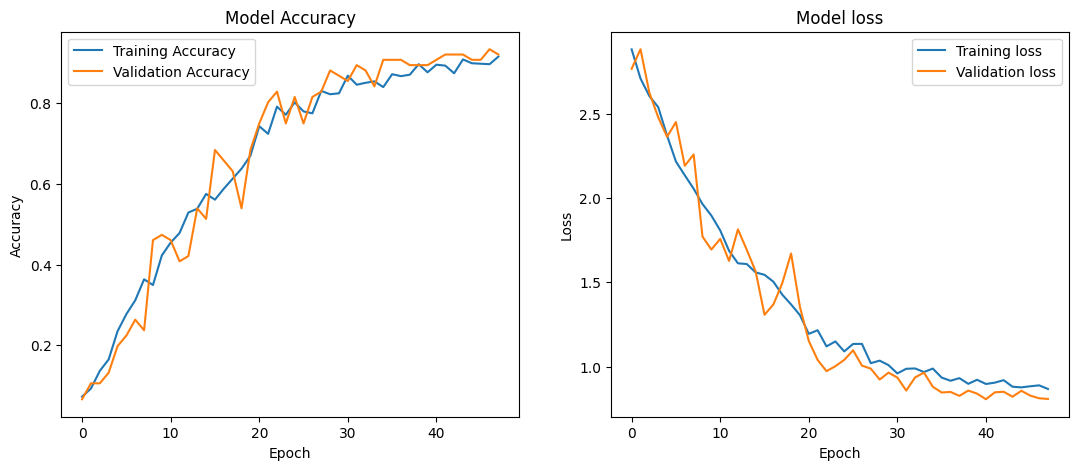

In [15]:


fig, axe = plt.subplots(1, 2, figsize=(13, 5))

axe[0].plot(history3.history['accuracy'], label='Training Accuracy')
axe[0].plot(history3.history['val_accuracy'], label='Validation Accuracy')
axe[0].set_title('Model Accuracy')
axe[0].set_ylabel('Accuracy')
axe[0].set_xlabel('Epoch')
axe[0].legend()

axe[1].plot(history3.history['loss'], label='Training loss')
axe[1].plot(history3.history['val_loss'], label='Validation loss')
axe[1].set_title('Model loss')
axe[1].set_ylabel('Loss')
axe[1].set_xlabel('Epoch')
axe[1].legend()
plt.show()

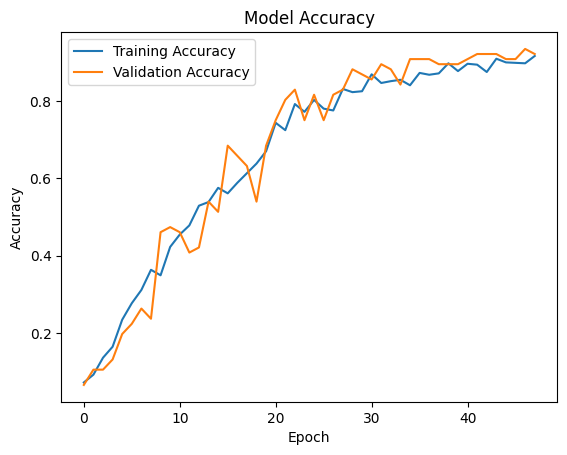

In [16]:
import matplotlib.pyplot as plt

plt.plot(history3.history['accuracy'], label='Training Accuracy')
plt.plot(history3.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [17]:
print("Train classes:", np.unique(np.argmax(y_train_cat, axis=1), return_counts=True))
print("Val classes:", np.unique(np.argmax(y_val_cat, axis=1), return_counts=True))


Train classes: (array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]), array([61, 62, 63, 64, 38, 62, 39, 59, 61, 60, 61, 58, 39, 61, 57]))
Val classes: (array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]), array([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 5, 5, 5]))
